In [396]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
sns.set_palette('colorblind')
sns.set_style('white')

In [16]:
import pandas as pd
import nltk
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report,confusion_matrix 

from sklearn.pipeline import Pipeline

from sklearn.grid_search import GridSearchCV

In [4]:
def get_data():
    df = pd.read_csv('newtrain.csv')
    return df

def get_test_data():
    df = pd.read_csv('newtest.csv')
    return df

In [5]:
def add_features(df):

    #tokenize text
    pattern = r'''(?x)    # set flag to allow verbose regexps
         ([A-Z]\.)+        # abbreviations, e.g. U.S.A.
       | \w+([-']\w+)*        # words with optional internal hyphens
       | \$?\d+(\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
       | [!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+  # these are separate tokens (string.punctuation)
     '''
    tokenize = lambda text: nltk.regexp_tokenize(text, pattern)
    df['Tokens'] = df['Text'].apply(tokenize)
    
    def pos_tag(text):
        tuples = nltk.pos_tag(text)
        tags = []
        for t in tuples:
            tags.append(t[1])
        return tags
    def get_nouns(text):
        wnlemmatizer = nltk.WordNetLemmatizer()
        tuples = nltk.pos_tag(text)
        tags = []
        for t in tuples:
            if t[1][0] == 'N':
                tags.append(wnlemmatizer.lemmatize(t[0]))
        return tags
    df['Nouns'] = df['Tokens'].apply(get_nouns)
    df['POS'] = df['Tokens'].apply(pos_tag)
    make_string = lambda a: ' '.join(i for i in a)
    df['Nouns'] = df['Nouns'].apply(make_string)
    df['POS'] = df['POS'].apply(make_string)
    
    df['TokenString'] = df['Tokens'].apply(make_string)
    
    return df

In [6]:
#vectorize data
#turns words into a list of vectors - vector length is the total number of words
#Vector elements correspond to 1 word (1/0 if word is/not present in the current item)
def featurize(df, test_df, max_f, targets=True):
    count_vec = CountVectorizer(analyzer = 'char_wb', ngram_range= (5,5), stop_words = ENGLISH_STOP_WORDS)
    noun_vec = CountVectorizer(analyzer = 'char_wb')
    pos_vec = CountVectorizer()
    vec_tar = LabelEncoder()
    targets = df['Category']
        
    counts = count_vec.fit_transform(df['Text'])
    #print("Counts shape: " + str(counts.shape))
    nouns = noun_vec.fit_transform(df['Nouns'])
    #print("Nouns shape: " + str(nouns.shape))
    pos = pos_vec.fit_transform(df['POS'])
    #print("POS shape: " + str(pos.shape))
    
    
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(counts)
    
    
    test = count_vec.transform(test_df['Text'])
    test = tfidf_transformer.transform(test)
    test_nouns = noun_vec.transform(test_df['Nouns'])
    test_pos = pos_vec.transform(test_df['POS'])
    
    #To combine or not to combine
    nouns_array = nouns.toarray()
    pos_array = pos.toarray()
    combined = np.hstack((nouns_array, pos_array))
    
    tnouns_array = test_nouns.toarray()
    tpos_array = test_pos.toarray()
    
    tcombined = np.hstack((tnouns_array, tpos_array))
    
    return targets, tfidf, test

In [7]:
#evaluate using 10 fold cross-validation, inspect results
#KNN WITH CV#
def cross_validate(targets, df):
    #SVC
    mod = LinearSVC(C=.1)
    cv = StratifiedShuffleSplit(targets, n_iter=10, test_size=.1)
    
    scores = []
    for tr, tt in cv:
        train = df.loc[tr]
        test = df.loc[tt]
        result = featurize(train, test, 1000)
        xtrain = result[1]
        xtest = result[2]
        mod.fit(xtrain, targets[tr])
        scores.append(mod.score(xtest, targets[tt]))

    print('\nLinear SVC\n\t mean score: {0}'.format(np.mean(scores)))
    
    #svm
    #mod = SGDClassifier(loss = 'hinge',penalty = 'L2',alpha = 1e-3)
    #scores = []
    #for tr, tt in cv:
    #    mod.fit(features[tr], targets[tr])
    #    scores.append(mod.score(features[tt],targets[tt]))
    #print('\nLinear SVM\n\t mean score: {0}'.format(np.mean(scores)))
    
    
    
    #naive bayes
    mod = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
    scores = []
    for tr, tt in cv:
        train = df.loc[tr]
        test = df.loc[tt]
        result = featurize(train, test, 1000)
        xtrain = result[1]
        xtest = result[2]
        mod.fit(xtrain, targets[tr])
        scores.append(mod.score(xtest, targets[tt]))
    print('\nNaive Bayes\n\t mean score: {0}'.format(np.mean(scores)))
    
    #logistic regression
    logreg = LogisticRegression()
    scores = []
    for tr, tt in cv:
        train = df.loc[tr]
        test = df.loc[tt]
        result = featurize(train, test, 1000)
        xtrain = result[1]
        xtest = result[2]
        mod.fit(xtrain, targets[tr])
        scores.append(mod.score(xtest, targets[tt]))
    print('\nLogReg\n\t mean score: {0}'.format(np.mean(scores)))
    

In [8]:
#get data and add features
df = get_data()
df = add_features(df)
df.head()

,Category,Text,Tokens,Nouns,POS,TokenString
0,5,why are yawns contagious? when people yawn,"[why, are, yawns, contagious, when, people, yawn]",yawn people,WRB VBP NNS JJ WRB NNS VBP,why are yawns contagious when people yawn
1,6,what is trans fat? how to reduce that? i heard...,"[what, is, trans, fat, how, to, reduce, that, ...",trans tras body food,WP VBZ NNS JJ WRB TO VB IN PRP VBP IN NNS VBP ...,what is trans fat how to reduce that i heard t...
2,1,roth ira vs 401k? what is the difference betwe...,"[roth, ira, vs, 401k, what, is, the, differenc...",roth ira v difference roth ira prefer,NN NN NNS CD WP VBZ DT NN IN NN NN CC CD WRB M...,roth ira vs 401k what is the difference betwee...
3,1,how many planes fedex has? i heard that it is ...,"[how, many, planes, fedex, has, i, heard, that...",plane fedex airline world,WRB JJ NNS NN VBZ PRP VBP IN PRP VBZ DT JJS NN...,how many planes fedex has i heard that it is t...
4,2,what is the best photo slideshow creation appl...,"[what, is, the, best, photo, slideshow, creati...",photo slideshow creation application photo sli...,WP VBZ DT JJS NN NN NN NN WP VBZ DT JJS NN NN ...,what is the best photo slideshow creation appl...


In [9]:
#combine columns
df['TokensNouns'] = df[['TokenString', 'Nouns']].apply(lambda x: ' '.join(x), axis=1)

In [10]:
df['TokensNouns'][0]

'why are yawns contagious when people yawn yawn people'

## grid search with CV

In [17]:
pipeline, parameters = [dict() for i in range(2)]
#set up cross validation folds
cv = StratifiedShuffleSplit(df.Category, n_iter=10, test_size=.2) 

#analysis pipeline with SVM
pipeline['svm'] = Pipeline([
    ('vect', CountVectorizer(stop_words = ENGLISH_STOP_WORDS)),
    ('tfidf', TfidfTransformer(use_idf = True)),
    ('clf', SVC(kernel = 'rbf')), 
])
parameters['svm'] = {
    'vect__ngram_range': ((1, 1), (1,3), (5, 5)),
    'vect__analyzer' : ('char_wb','word'),
    'clf__C': (1, 1e3, 1e-3)}


#analysis pipeline with logistic regression
pipeline['log'] = Pipeline([
    ('vect', CountVectorizer(stop_words = ENGLISH_STOP_WORDS)),
    ('tfidf', TfidfTransformer(use_idf = True)),
    ('clf', LogisticRegression(penalty = 'l2', solver = 'lbfgs', multi_class = 'multinomial'))
])
parameters['log'] = {
    'vect__ngram_range': ((1, 1), (1,2), (1,3), (5, 5)),
    'vect__analyzer' : ('char_wb','word'),
    'clf__C': (1, 1e3, 1e-3)}

#analysis pipeline with naive bayes
pipeline['nb'] = Pipeline([
    ('vect', CountVectorizer(stop_words = ENGLISH_STOP_WORDS)),
    ('tfidf', TfidfTransformer(use_idf = True)),
    ('clf', MultinomialNB(fit_prior = True))])
parameters['nb'] = {
    'vect__ngram_range': ((1, 1), (1,2), (1,3), (5, 5)),
    'vect__analyzer' : ('char_wb','word')}


#fit grid search instance
for m in ['svm','log','nb']:
    gs_clf = GridSearchCV(pipeline[m], parameters[m], verbose = 1, cv = cv, n_jobs = -1)

    gs_clf = gs_clf.fit(df['TokensNouns'], df.Category)

    best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1]) #find best params

    print ('{0}:\n\tbest score: {1}\nparameters: {2}'.format(m, score, best_parameters))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 174 out of 180 | elapsed:  2.7min remaining:    5.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.7min finished


svm:
	best score: 0.4397031539888683
parameters: {'clf__C': 1000.0, 'vect__analyzer': 'word', 'vect__ngram_range': (1, 1)}
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 234 out of 240 | elapsed:  2.5min remaining:    3.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.5min finished


log:
	best score: 0.562152133580705
parameters: {'clf__C': 1000.0, 'vect__analyzer': 'word', 'vect__ngram_range': (1, 3)}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   11.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.5s finished


nb:
	best score: 0.4725417439703154
parameters: {'vect__analyzer': 'word', 'vect__ngram_range': (1, 1)}


## manually set parameters (no grid search)

In [307]:
## vectorize data
#targets
vec_tar = LabelEncoder()
targets = vec_tar.fit_transform(df['Category'])
#counts
vec = CountVectorizer(analyzer = 'char_wb', ngram_range= (5,5), stop_words = ENGLISH_STOP_WORDS) #use character ngrmas more robust against mispellings (ngrams within word boundaries)

counts = vec.fit_transform(df['Text']) 

In [308]:
feature_labels = vec.get_feature_names()
feature_labels[495:500]

[' bath', ' batm', ' batt', ' bay ', ' bbl ']

In [309]:
## cv folds
cv = StratifiedShuffleSplit(targets, n_iter=10, test_size=.1)

## calculate tf-idf
tfidf_transformer = TfidfTransformer()
counts_tfidf = tfidf_transformer.fit_transform(counts)

#svm
mod = SGDClassifier(loss = 'hinge',penalty = 'L2',alpha = 1e-3)
scores = []
for tr, tt in cv:
    mod.fit(counts_tfidf[tr], targets[tr])
    scores.append(mod.score(counts_tfidf[tt],targets[tt]))
print('\nLinear SVM\n\t mean score: {0}'.format(np.mean(scores)))


Linear SVM
	 mean score: 0.5688888888888888


## other stuff not currently used

In [ ]:
## vectorize data
#targets
vec_tar = LabelEncoder()
targets = vec_tar.fit_transform(df['Category'])
#counts
vec = CountVectorizer(analyzer = 'char_wb', ngram_range= (5,5), stop_words = ENGLISH_STOP_WORDS) 
counts = vec.fit_transform(df['TokensNouns']) 

## cv folds
cv = StratifiedShuffleSplit(targets, n_iter=10, test_size=.1)

## calculate tf-idf
tfidf_transformer = TfidfTransformer()
counts_tfidf = tfidf_transformer.fit_transform(counts)

#nb
mod = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
scores = []
for tr, tt in cv:
    mod.fit(counts_tfidf[tr], targets[tr])
    scores.append(mod.score(counts_tfidf[tt],targets[tt]))
print('\nNaive Bayes\n\t mean score: {0}'.format(np.mean(scores)))


In [244]:
'''
#linear SVC
mod = LinearSVC(C=.1)
scores = []
for tr, tt in cv:
    mod.fit(counts_tfidf[tr], targets[tr])
    scores.append(mod.score(counts_tfidf[tt],targets[tt]))
print('\nLinear SVC\n\tmean score: {0}'.format(np.mean(scores)))

#naive bayes
mod = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
scores = []
for tr, tt in cv:
    mod.fit(counts_tfidf[tr], targets[tr])
    scores.append(mod.score(counts_tfidf[tt],targets[tt]))
print('\nNaive Bayes\n\t mean score: {0}'.format(np.mean(scores)))


#decision tree
mod = DecisionTreeClassifier(criterion = 'entropy')
cv = StratifiedShuffleSplit(targets, n_iter = 10, test_size = 0.1)

scores = []
for tr, tt in cv:
    mod.fit(counts[tr], targets[tr])
    scores.append(mod.score(counts[tt],targets[tt]))
print('\nDecision Tree\n\t mean score: {0}'.format(np.mean(scores)))
'''


Linear SVC
	mean score: 0.49407407407407405

Naive Bayes
	 mean score: 0.4681481481481482

Linear SVM
	 mean score: 0.571111111111111


"\n#decision tree\nmod = DecisionTreeClassifier(criterion = 'entropy')\ncv = StratifiedShuffleSplit(targets, n_iter = 10, test_size = 0.1)\n\nscores = []\nfor tr, tt in cv:\n    mod.fit(counts[tr], targets[tr])\n    scores.append(mod.score(counts[tt],targets[tt]))\nprint('\nDecision Tree\n\t mean score: {0}'.format(np.mean(scores)))\n"

In [245]:
#top features
feature_sum = counts.toarray().sum(axis=0)

df_feature_sum = pd.DataFrame({'counts': feature_sum})
df_feature_sum.index = vec.get_feature_names()

print (df_feature_sum.sort('counts', ascending=False).iloc[1])
df_feature_sum.sort('counts', ascending=False).iloc[3]
#problem - words followed by spaces

counts    235
Name:  does, dtype: int64


counts    211
Name:  does , dtype: int64

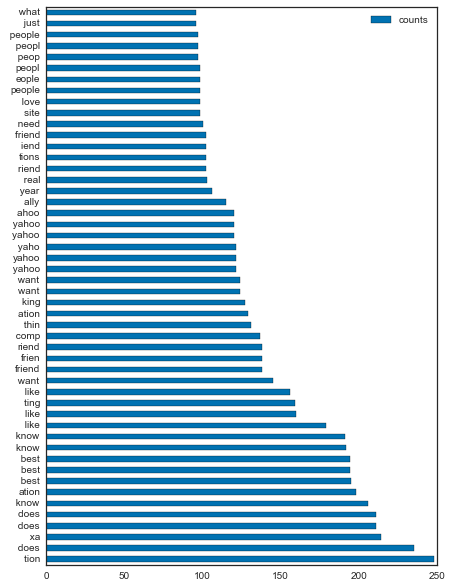

In [246]:
df_feature_sum.sort('counts', ascending=False)[:50].plot(kind='barh', figsize=(7,10));

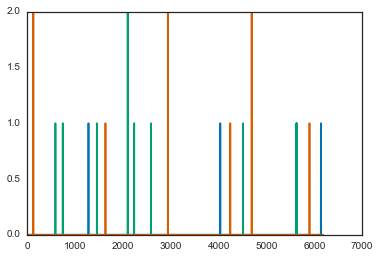

In [69]:
#each color is a question, x axis is the words, y axis is the counts (like histogram)
plt.plot(counts[:3,:].toarray().T)

In [119]:
top_words = {}
for itrg in np.unique(targets):
    cat = vec_tar.classes_[itrg]
    # Pull rows for the current category, sum all rows (each element is a word)
    icounts = counts[targets == itrg, :].sum(0).squeeze() 
    
    # Which word counts occured >5 times
    mask_top_words = icounts > 5
    
    # Turns vectors back into actual words (inverse transform - magical!)
    top_words[cat] = vec.inverse_transform(mask_top_words)[0]

In [19]:
#keep words that are unique to that category
unique_words = {}
for cat, words in zip(top_words.keys(), top_words.values()):
    others = top_words.copy()
    others.pop(cat)
    unique_words[cat] = [wrd for wrd in top_words[cat]
                         if wrd not in np.hstack(others.values())]

In [153]:
#try SVC
mod = LinearSVC(C=.1)
cv = StratifiedShuffleSplit(targets, n_iter=10, test_size=.1)

coefs, scores = [[] for i in range(2)]
for tr, tt in cv:
    mod.fit(counts[tr], targets[tr])
    coefs.append(mod.coef_)
    print(mod.score(counts[tt], targets[tt]))
    scores.append(mod.score(counts[tt],targets[tt]))
coefs = np.array(coefs).mean(0)

print('Linear SVC mean score: {0}'.format(np.mean(scores)))

0.511111111111
0.566666666667
0.537037037037
0.503703703704
0.503703703704
0.537037037037
0.525925925926
0.511111111111
0.544444444444
0.522222222222
Linear SVC mean score: 0.5262962962962963


In [154]:
#try Naive Bayes
mod = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
cv = StratifiedShuffleSplit(targets, n_iter = 10, test_size = 0.1)

coefs = []
for tr, tt in cv:
    mod.fit(counts[tr], targets[tr])
    coefs.append(mod.coef_)
    print(mod.score(counts[tt], targets[tt]))
    scores.append(mod.score(counts[tt],targets[tt]))
coefs = np.array(coefs).mean(0)

print('Naive Bayes mean score: {0}'.format(np.mean(scores)))

0.52962962963
0.57037037037
0.518518518519
0.548148148148
0.577777777778
0.562962962963
0.57037037037
0.566666666667
0.588888888889
0.581481481481
Naive Bayes mean score: 0.5438888888888889


In [146]:
#look only at highly weighted
for cat, icoef in zip(vec_tar.classes_, coefs):
    cut = np.percentile(icoef, 99)
    important = icoef > cut
    print('{0}: {1}'.format(cat, vec.inverse_transform(important)))

1: [array(['best', 'does', 'good', 'know', 'like', 'make', 'need', 'people',
       'want', 'yahoo'], 
      dtype='<U13')]
2: [array(['best', 'computer', 'does', 'know', 'use', 'want', 'web', 'windows',
       'xa', 'yahoo'], 
      dtype='<U13')]
3: [array(['best', 'did', 'does', 'favorite', 'know', 'like', 'movie', 'music',
       'song', 'xa'], 
      dtype='<U13')]
4: [array(['boyfriend', 'does', 'friend', 'girl', 'guy', 'know', 'like',
       'love', 'really', 'want'], 
      dtype='<U13')]
5: [array(['best', 'college', 'does', 'good', 'help', 'know', 'need', 'school',
       'word', 'xa'], 
      dtype='<U13')]
6: [array(['bad', 'best', 'does', 'feel', 'good', 'help', 'know', 'like',
       'pain', 'way'], 
      dtype='<U13')]
7: [array(['does', 'earth', 'gas', 'life', 'make', 'really', 'tell', 'theory',
       'world', 'xa'], 
      dtype='<U13')]
